

<p style="text-align:center; color:blue; font-size:30px;">PyMCon Web Series</p>


<p style="text-align:center; color:green; font-size:40px;">An introduction to multi-output Gaussian processes using PyMC</p>



<p style="text-align:center; font-size:25px;">Danh Phan</p>



<p style="text-align:center; font-size:20px;">Linkedin: <a href="https://www.linkedin.com/in/danhpt">@danhpt</a> Twitter: <a href="https://twitter.com/danhpt">@danhpt</a></p>
<p style="text-align:center; font-size:20px;">Website: <a href="http://danhphan.net/">http://danhphan.net</a></p>

<p style="text-align:center; font-size:15px;">Feb 2023</p>

## 1. Introduction

We have a training set D, where $$D=\{(x_i,y_i) | i=1,...,N\}$$
where $y_t$ is a scalar output, and $x_t$ is a general input vector.

All input vectors are often aggregated into a matrix $X$, and the output vector $y$ for the output values.

$$X = \begin{bmatrix} x_1 \\ x_2 \\ ... \\ x_N \end{bmatrix} y = \begin{bmatrix} y_1 \\ y_2 \\ ... \\ y_N \end{bmatrix}$$

A general model is given by
$$y_i = f(x_i,\theta) + \epsilon_t$$
$$ \epsilon_i \sim N(0, \sigma) $$
For simplicity, let's assume $x_i$ is scalar.

### Bayesian Linear Regression

$$f(x_i, \theta) = \beta_0 + \beta_1 x_i$$
where $$\theta = [\beta_0, \beta_1]$$
So $$y_i = f(x_i,\theta) + \epsilon_i = \beta_0 + \beta_1 x_i + \epsilon_i$$

The parameter $\theta$ is inferred through Bayes' rule

$$P(\theta|X,y) = \frac{P(y|X,\theta) \times P(\theta)}{P(y|X)} = \frac{P(y|X,\theta) \times P(\theta)}{\int P(y|X,\theta)P(\theta) d\theta} = \frac{likelihood * prior}{evidence \  or \  marginal \  likelihood}$$

### Gaussian Process

- The primary goal of the forecasting model is to compute the underlying function $f$ from the noisy observation $y$
- In a parametric model such as Bayesian Linear Regression, we obtain the function $f$ through the parameter $\theta$
- If we less interested in $\theta$, and more interested in model predictive capability => Can infer $f$ directly!

**The function $f$ is random and we need to assign a probability distribution over f**

Rasmussen and Williams suggest the Gaussian processes (GP) to describe the probability distribution over function $𝑓$:

***A Gaussian process is a collection of random variables, any finite number of which have a
joint Gaussian distribution.***

By this definition, a value of a function 𝑓 evaluated at a point 𝐱 is distributed according to a multivariate
Gaussian distribution

$$\begin{bmatrix} f(x_i) \\ f(x_j) \\ f(x_k) \\ ... \end{bmatrix}  = \mathcal{N}\Bigg(\begin{bmatrix} m(x_i) \\ m(x_j) \\ m(x_k) \\ ... \end{bmatrix}, \begin{bmatrix} k(x_i,x_i) & k(x_i,x_j) & k(x_i,x_k) & ... \\ k(x_j,x_i) & k(x_j,x_j) & k(x_j,x_k) & ... \\ k(x_k,x_i) & k(x_k,x_j) & k(x_k,x_k) & ... \\ ... & ... & ... & ... \end{bmatrix}\Bigg) $$

where $m$ and $k$ denote the **mean** and **covariance functions** (*kernels*) respectively. As an alternative way define a function that is distributed according to a Gaussian process as:

$$f(x) = \mathcal{GP}(m(x), k(x,x')$$

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

Data shape:  (40, 2)


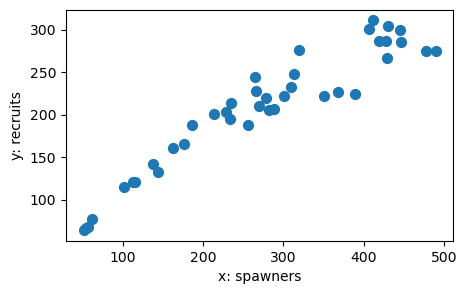

In [2]:
salmon_data = pd.read_table('./data/salmon.txt', sep='\s+', index_col=0)
print("Data shape: ", salmon_data.shape)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50, figsize=(5,3));
plt.xlabel("x: spawners");
plt.ylabel("y: recruits");

### Bayesian Linear Regression in PyMC

Simple linear regression:

$$ y_i = \beta_0 + \beta_1 x_i + \epsilon_i $$

There are three unknowns, each of which need to be given a prior:

$$\beta_0, \beta_1 \sim \text{Normal}(0, 50)$$

$$\sigma \sim \text{HalfNormal}(50)$$

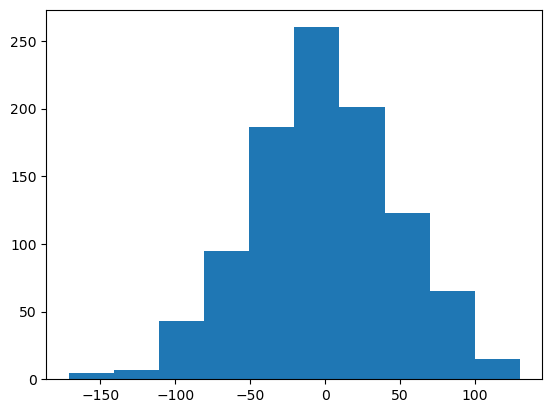

In [3]:

a_normal_distribution = pm.Normal.dist(mu=0, sigma=50)
plt.hist(pm.draw(a_normal_distribution, draws=1000));

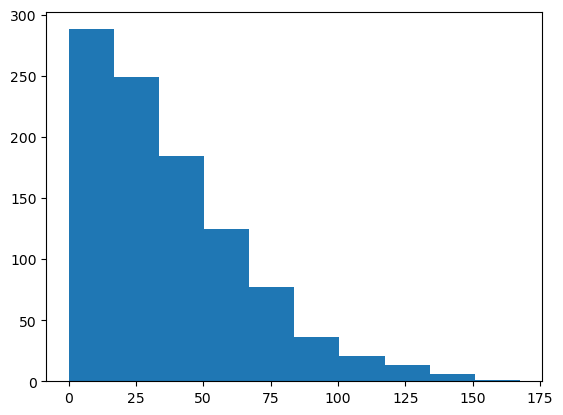

In [4]:
a_half_normal_distribution = pm.HalfNormal.dist(sigma=50)
plt.hist(pm.draw(a_half_normal_distribution, draws=1000));

In [5]:
x, y = salmon_data[['spawners', 'recruits']].values.T
x.shape, y.shape

((40,), (40,))

In [6]:
with pm.Model() as linear_salmon_model:
    
    β = pm.Normal('β', mu=0, sigma=50, shape=2)
    σ = pm.HalfNormal('σ', sigma=50)    
    μ = β[0] + β[1] * x    
    recruits = pm.Normal('recruits', mu=μ, sigma=σ, observed=y)

In [7]:
with linear_salmon_model:    
    linear_trace = pm.sample(1000, tune=2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, σ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 4 seconds.


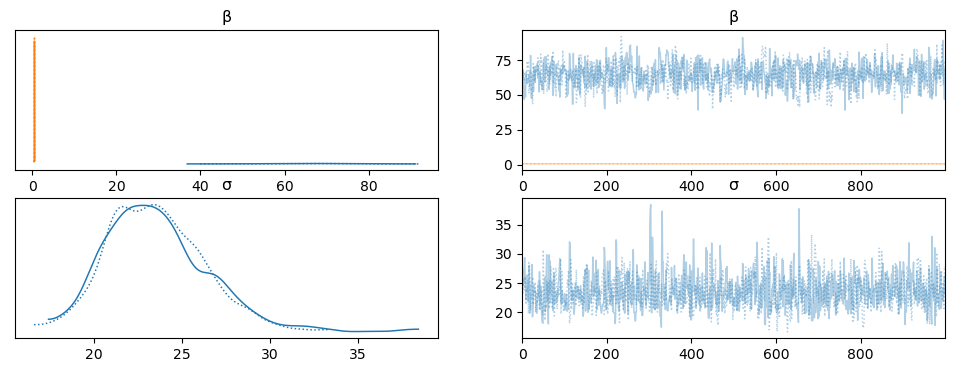

In [8]:
az.plot_trace(linear_trace);

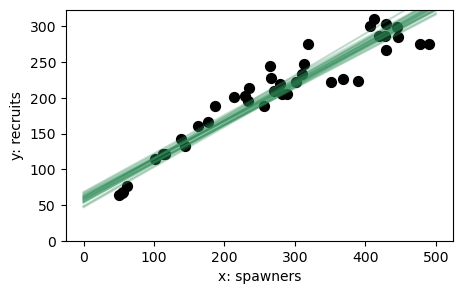

In [9]:
X_pred = np.linspace(0, 500, 100)

ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, figsize=(5,3))
ax.set_ylim(0, None)
for b0,b1 in linear_trace.posterior['β'].sel(chain=0)[:20,:]:
#     print(b0.values,b1.values)
    b0,b1=b0.values,b1.values
    ax.plot(X_pred, b0 + b1*X_pred, alpha=0.3, color='seagreen');
plt.xlabel("x: spawners");
plt.ylabel("y: recruits");

## Gaussian Process

In [10]:
with pm.Model() as gp_salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)

In [11]:
with gp_salmon_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ρ, η, σ]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 23 seconds.


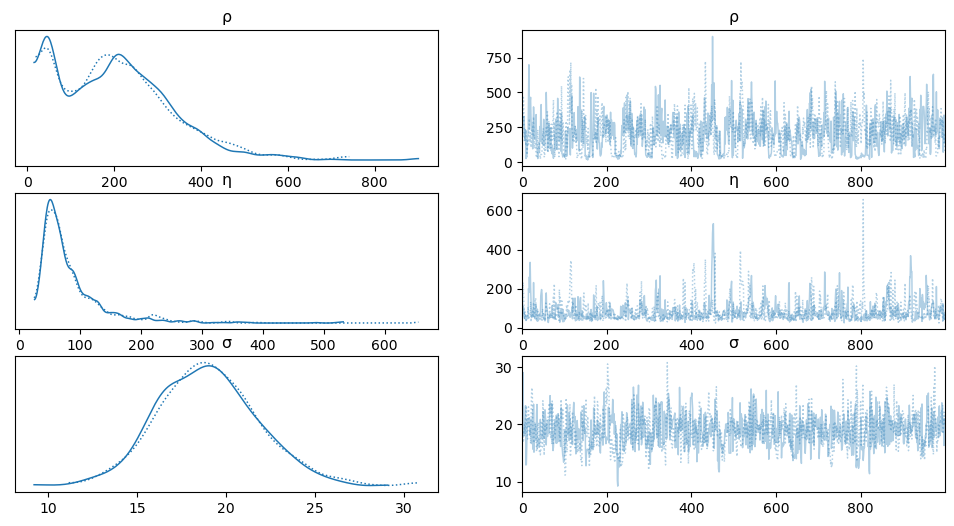

In [12]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [13]:
with gp_salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred.reshape(-1, 1))

In [14]:
with gp_salmon_model:
    gp_salmon_samples = pm.sample_posterior_predictive(gp_trace, var_names=['salmon_pred'])

Sampling: [salmon_pred]


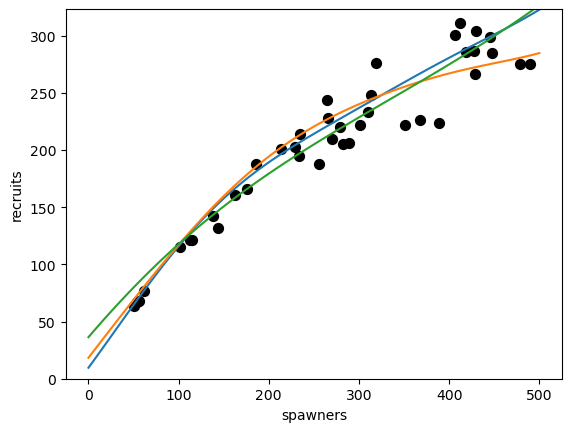

In [15]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in gp_salmon_samples.posterior_predictive['salmon_pred'].sel(chain=0)[:3,:]:
    ax.plot(X_pred, x);

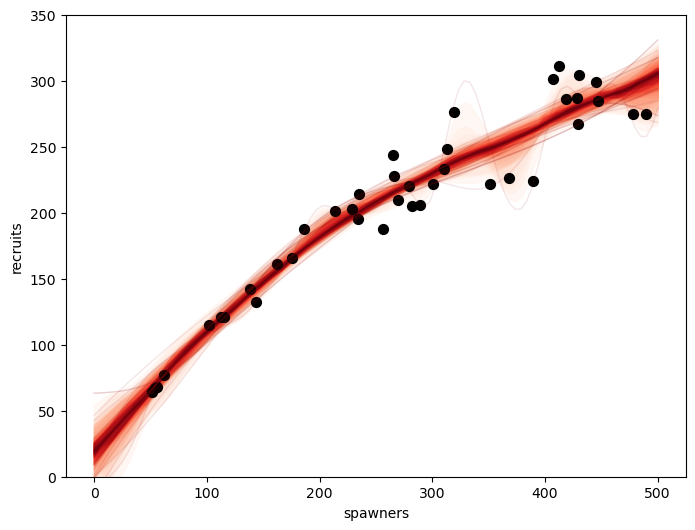

In [16]:
from pymc.gp.util import plot_gp_dist
fig, ax = plt.subplots(figsize=(8,6))
plot_gp_dist(ax, gp_salmon_samples.posterior_predictive['salmon_pred'].sel(chain=0)[:50,:], X_pred)
salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50, ax=ax)
ax.set_ylim(0, 350);

## Gaussian Process: Kernels

## 5. More on PyMC

### Examples and applications!

<img src="images/pymc_examples.png" alt="PyMC" style="width:500px;"/>

See PyMC Documentation: [Example Gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html)

## References

### Theory
- [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) by Richard McElreath
- [Statistical Rethinking in PyMC](https://github.com/pymc-devs/pymc-resources/tree/main/Rethinking_2)

### PyMC

- [A Modern Introduction to Probabilistic Programming with PyMC](https://austinrochford.com/posts/intro-prob-prog-pymc.html#Robust-regression) by Austin Rochford
- PyMC [quickstart guide](https://www.pymc.io/projects/examples/en/latest/howto/api_quickstart.html), [tutorial](https://docs.pymc.io/en/latest/learn/core_notebooks/pymc_overview.html), and [example gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html)
- Book: [Bayesian Analysis with Python](https://www.packtpub.com/big-data-and-business-intelligence/bayesian-analysis-python-second-edition)
- Book: [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- Book: [Bayesian Modeling and Computation in Python](https://bayesiancomputationbook.com/welcome.html)

### Code
- https://github.com/danhphan/workshops

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 29 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.9.0

arviz     : 0.14.0
numpy     : 1.23.5
pandas    : 1.5.3
matplotlib: 3.6.3
pymc      : 5.0.2

Watermark: 2.3.1

